<a href="https://colab.research.google.com/github/hpan270/MSA/blob/master/keras_cifar10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [12]:
from __future__ import print_function
import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
import os

batch_size = 128
num_classes = 10
epochs = 32
data_augmentation = True
num_predictions = 20

# The data, split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

# initiate RMSprop optimizer
opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)

# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [13]:
json_str=model.to_json()
open("keras_cifar10_aug.json",'w').write(json_str)

4998

In [0]:
from keras import callbacks

In [0]:
csvlogger=callbacks.CSVLogger('keras_cifar10_csvlogger_aug.csv',separator=',',append=False)
chkpt=callbacks.ModelCheckpoint('keras_cifar10_chkpt_aug.hdf5',verbose=1, save_best_only=True)#for augment=false, otherwise=true

In [18]:
if not data_augmentation:
  print('Not using data augmentation.')
  model.fit(x_train, y_train,
            batch_size=batch_size,
            epochs=epochs,
            validation_split=0.2,
            callbacks=[csvlogger,chkpt],
            shuffle=True)
else:
  print('Using real-time data augmentation.')
  # This will do preprocessing and realtime data augmentation:
  datagen = ImageDataGenerator(
      featurewise_center=False,  # set input mean to 0 over the dataset
      samplewise_center=False,  # set each sample mean to 0
      featurewise_std_normalization=False,  # divide inputs by std of the dataset
      samplewise_std_normalization=False,  # divide each input by its std
      zca_whitening=False,  # apply ZCA whitening
      zca_epsilon=1e-06,  # epsilon for ZCA whitening
      rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
      # randomly shift images horizontally (fraction of total width)
      width_shift_range=0.1,
      # randomly shift images vertically (fraction of total height)
      height_shift_range=0.1,
      shear_range=0.,  # set range for random shear
      zoom_range=0.,  # set range for random zoom
      channel_shift_range=0.,  # set range for random channel shifts
      # set mode for filling points outside the input boundaries
      fill_mode='nearest',
      cval=0.,  # value used for fill_mode = "constant"
      horizontal_flip=True,  # randomly flip images
      vertical_flip=False,  # randomly flip images
      # set rescaling factor (applied before any other transformation)
      rescale=None,
      # set function that will be applied on each input
      preprocessing_function=None,
      # image data format, either "channels_first" or "channels_last"
      data_format=None,
      # fraction of images reserved for validation (strictly between 0 and 1)
      validation_split=0.0)

  # Compute quantities required for feature-wise normalization
  # (std, mean, and principal components if ZCA whitening is applied).
  datagen.fit(x_train)

  # Fit the model on the batches generated by datagen.flow().
  model.fit_generator(datagen.flow(x_train, y_train,batch_size=batch_size),
                      epochs=epochs,
                      steps_per_epoch=x_train.__len__()/10,
                      validation_data=(x_test, y_test),
                      callbacks=[csvlogger,chkpt],
                      shuffle=True)

Using real-time data augmentation.
Epoch 1/32
5000/5000 [==============================] - 236s 47ms/step - loss: 0.9005 - acc: 0.6841 - val_loss: 0.7402 - val_acc: 0.7459

Epoch 00001: val_loss improved from 0.86368 to 0.74016, saving model to keras_cifar10_chkpt_aug.hdf5
Epoch 2/32
5000/5000 [==============================] - 236s 47ms/step - loss: 0.8160 - acc: 0.7151 - val_loss: 0.6658 - val_acc: 0.7688

Epoch 00002: val_loss improved from 0.74016 to 0.66577, saving model to keras_cifar10_chkpt_aug.hdf5
Epoch 3/32
5000/5000 [==============================] - 236s 47ms/step - loss: 0.7609 - acc: 0.7354 - val_loss: 0.6658 - val_acc: 0.7751

Epoch 00003: val_loss did not improve from 0.66577
Epoch 4/32
5000/5000 [==============================] - 236s 47ms/step - loss: 0.7235 - acc: 0.7493 - val_loss: 0.6358 - val_acc: 0.7802

Epoch 00004: val_loss improved from 0.66577 to 0.63584, saving model to keras_cifar10_chkpt_aug.hdf5
Epoch 5/32
5000/5000 [==============================] - 237

In [20]:
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

10000/10000 [==============================] - 1s 91us/step
Test loss: 0.5022342145442963
Test accuracy: 0.8302


In [0]:
!ls -lht

In [0]:
# from google.colab import files

# files.download('keras_cifar10_chkpt_aug.hdf5')
# files.download('keras_cifar10_aug.json')
# files.download('keras_cifar10_csvlogger_aug.csv')

Below code is to plot the cnn training result and scores

In [22]:
from keras.models import Sequential
from keras.optimizers import Adam
from keras.models import model_from_json

themodel=model_from_json(open('keras_cifar10_aug.json').read())  
themodel.load_weights('keras_cifar10_chkpt_aug.hdf5')
themodel.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

themodel.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_13 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 30, 30, 32)        9248      
_________________________________________________________________
activation_14 (Activation)   (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 15, 15, 64)        18496     
__________

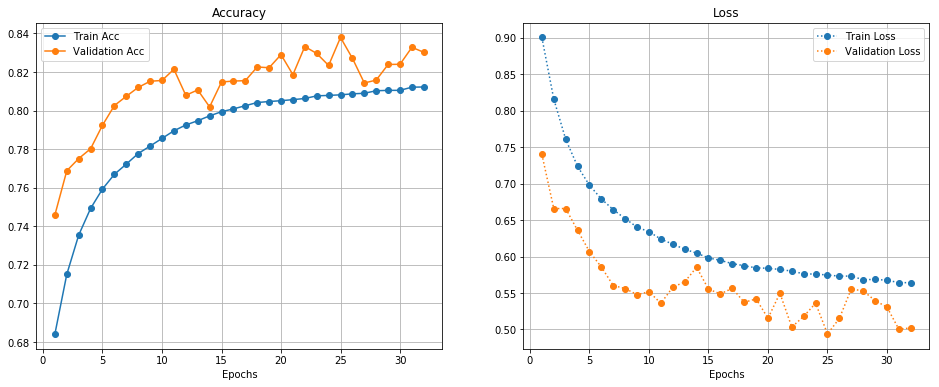

In [23]:
#plot the train/validation acc/loss in plot
import pandas as pd
import matplotlib.pyplot as plt
train_rslt=pd.read_csv('keras_cifar10_csvlogger_aug.csv',sep=',')
train_rslt.epoch=train_rslt.epoch+1
f=plt.figure(figsize=[16,6])
plt.subplot(1,2,1)
plt.plot(train_rslt['epoch'], train_rslt['acc'],'-o', label='Train Acc')
plt.plot(train_rslt['epoch'], train_rslt['val_acc'],'-o',label='Validation Acc')  
plt.title("Accuracy")
plt.xlabel("Epochs")
plt.grid()
plt.legend(loc='best')
plt.subplot(1,2,2)
plt.plot(train_rslt['epoch'], train_rslt['loss'],':o', label='Train Loss')
plt.plot(train_rslt['epoch'], train_rslt['val_loss'],':o',label='Validation Loss')  
plt.title("Loss")
plt.xlabel("Epochs")
plt.grid()
plt.legend(loc='best')


In [24]:
import numpy as np
labels_test=[x.argmax() for x in y_test[::1,:]]
type(labels_test)
print(labels_test[:5])

ypred=themodel.predict(x_test)
pred_labels=[x.argmax() for x in ypred[::1,:]]
pred_labels[:5]

[3, 8, 8, 0, 6]


[3, 8, 8, 8, 6]

In [25]:
#metrics report
from sklearn.metrics import classification_report
crpt=classification_report(labels_test,pred_labels)
print(crpt)

              precision    recall  f1-score   support

           0       0.83      0.86      0.85      1000
           1       0.93      0.92      0.92      1000
           2       0.87      0.68      0.76      1000
           3       0.72      0.70      0.71      1000
           4       0.83      0.81      0.82      1000
           5       0.81      0.75      0.78      1000
           6       0.76      0.95      0.85      1000
           7       0.89      0.87      0.88      1000
           8       0.85      0.93      0.89      1000
           9       0.90      0.90      0.90      1000

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.84      0.84      0.84     10000



0.8379


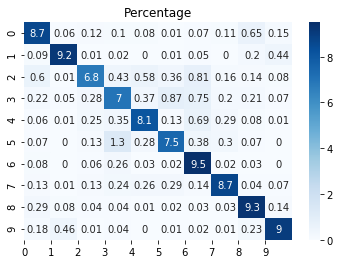

In [26]:
#confusion matrix and heatmap plot and matshow plot
from sklearn.metrics import confusion_matrix
import seaborn as sn
mx=confusion_matrix(labels_test, pred_labels)
print((np.array(pred_labels)==np.array(labels_test)).mean())
f=plt.figure()
sn.heatmap(mx/100, annot=True, cmap=plt.cm.Blues) #plot percent, total 10k test labels
plt.xticks(ticks=range(10))
plt.title('Percentage')
plt.show()